# Qiskit Machine Learning

In [21]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.primitives import Sampler
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit.circuit import ParameterVector

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.circuit.library import QNNCircuit


## Instantiating EstimatorQNN

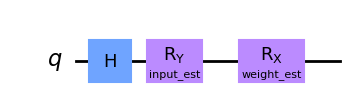

In [2]:
params_est = [Parameter("input_est"), Parameter("weight_est")]
qc_est = QuantumCircuit(1)
qc_est.h(0)
qc_est.ry(params_est[0], 0)
qc_est.rx(params_est[1], 0)
qc_est.draw("mpl", style="clifford")

In [3]:
observable_est = SparsePauliOp.from_list([("Y" * qc_est.num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc_est, observables=observable_est, input_params=[params_est[0]], weight_params=[params_est[1]]
)
estimator_qnn

## Instantiating SamplerQNN

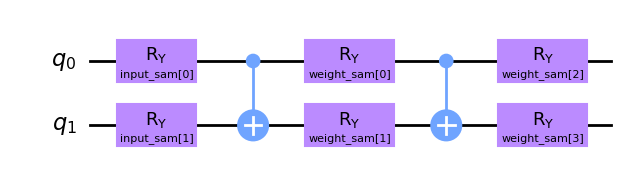

In [2]:
inputs_sam = ParameterVector("input_sam", 2)
weights_sam = ParameterVector("weight_sam", 4)

qc_sam = QuantumCircuit(2)
qc_sam.ry(inputs_sam[0], 0)
qc_sam.ry(inputs_sam[1], 1)
qc_sam.cx(0, 1)
qc_sam.ry(weights_sam[0], 0)
qc_sam.ry(weights_sam[1], 1)
qc_sam.cx(0, 1)
qc_sam.ry(weights_sam[2], 0)
qc_sam.ry(weights_sam[3], 1)

qc_sam.draw("mpl", style="clifford")

In [3]:
sampler_qnn = SamplerQNN(circuit=qc_sam, input_params=inputs_sam, weight_params=weights_sam)
sampler_qnn

## Forward Pass

In [4]:
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)

print(
    f"Number of Input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weights}"
)

Number of Input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]


In [ ]:
# Define the SamplerQNN random input values and weughts

### Non-Batched Forward Pass

In [8]:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(
    f"Forward Pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]]. 
Shape: (1, 1)


In [ ]:
# Define the SamplerQNN non-batched forward pass here

### Batched Forward Pass

In [9]:
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward_batched}.  \nShape: {estimator_qnn_forward_batched.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]
 [0.2970094]].  
Shape: (2, 1)


In [ ]:
# Define the SamplerQNN batched forward pass here

## Backward Pass

### Backward Pass without Input Gradients

In [6]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients with EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad}"
)
print(
    f"Weight gradients with EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients with EstimatorQNN: None.  
Shape: None
Weight gradients with EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


In [ ]:
# Define the SamplerQNN  backward pass without gradients here

### Backward Pass with Input Gradients

In [5]:
estimator_qnn.input_gradients = True
#sampler_qnn.input_gradients = True

estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad.shape}"
)
print(
    f"Weight gradients EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients EstimatorQNN: [[[0.3038852]]].  
Shape: (1, 1, 1)
Weight gradients EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


In [ ]:
# Define the SamplerQNN  backward pass with gradients here

## EstimatorQNN based Classification

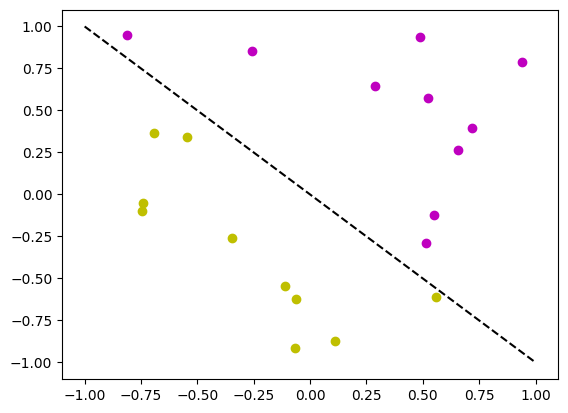

In [2]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "mo")
    else:
        plt.plot(x[0], x[1], "yo")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

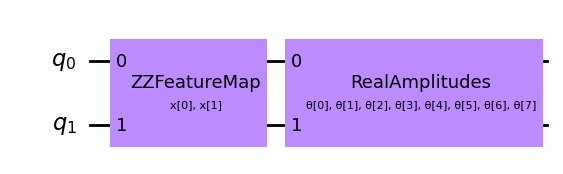

In [3]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [4]:
estimator_qnn = EstimatorQNN(circuit=qc)

# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

In [5]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

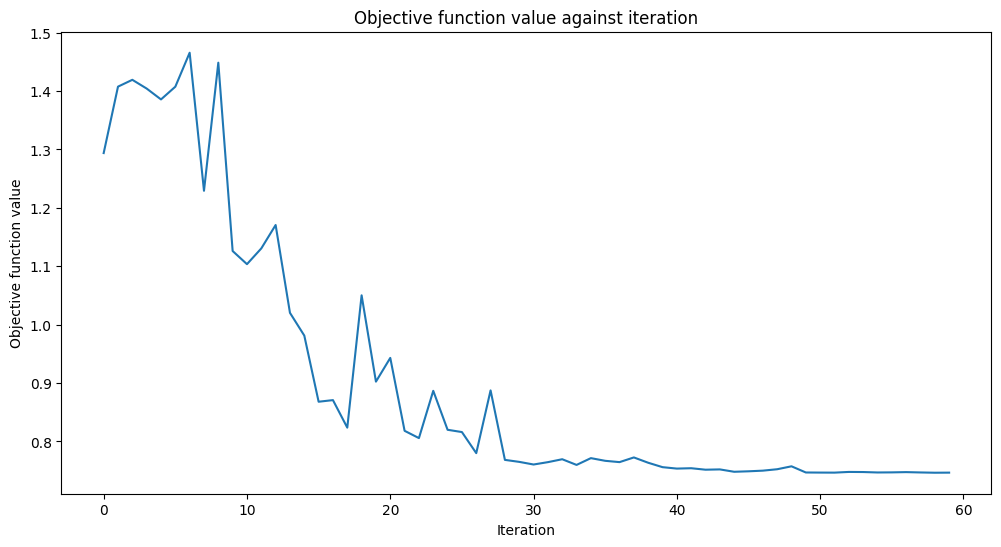

0.8

In [7]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

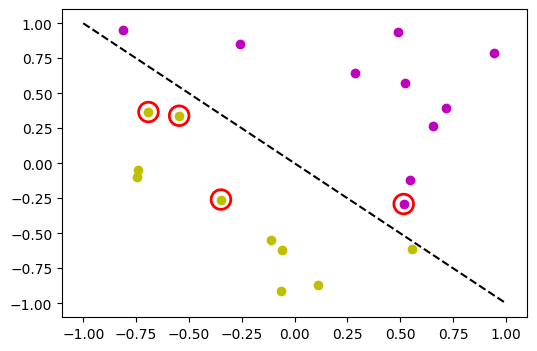

In [8]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "mo")
    else:
        plt.plot(x[0], x[1], "yo")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [9]:
estimator_classifier.weights

array([ 7.99142399e-01, -1.02869770e+00, -1.32131512e-04, -3.47046684e-01,
        1.13636802e+00,  6.56831727e-01,  2.17902158e+00, -1.08678332e+00])

## Variational Quantum Classifier on Real World Dataset

### Loading the dataset

In [10]:
iris_data = load_iris()
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [11]:
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)

### Support Vector Classifer - Classical Training 

In [12]:
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [13]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


### Variational Quantum Classifier Training

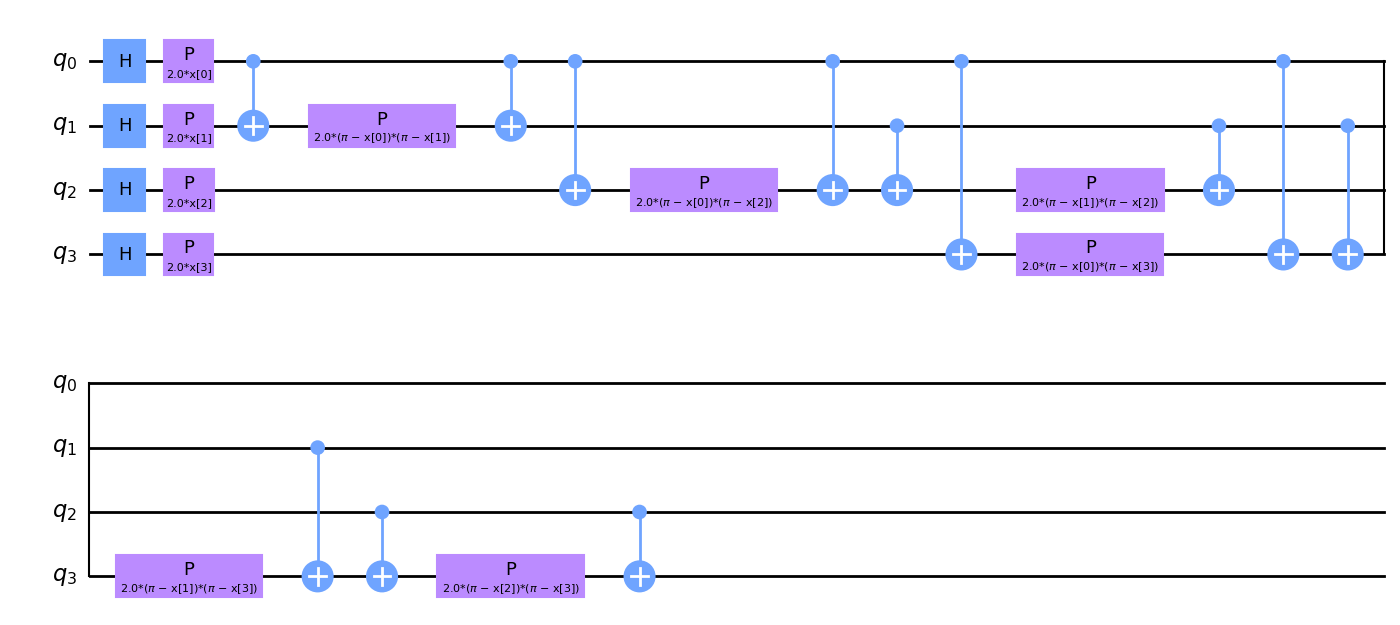

In [14]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

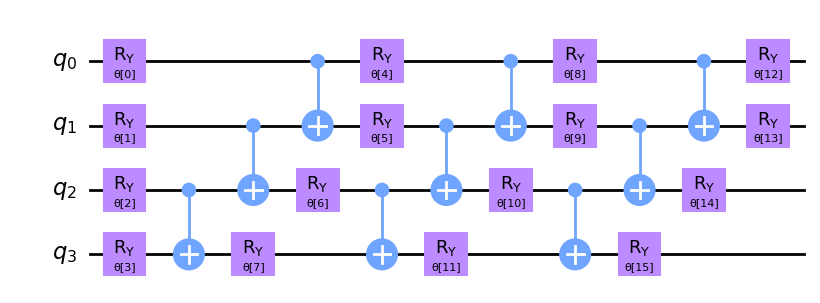

In [15]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [16]:
optimizer = COBYLA(maxiter=100)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

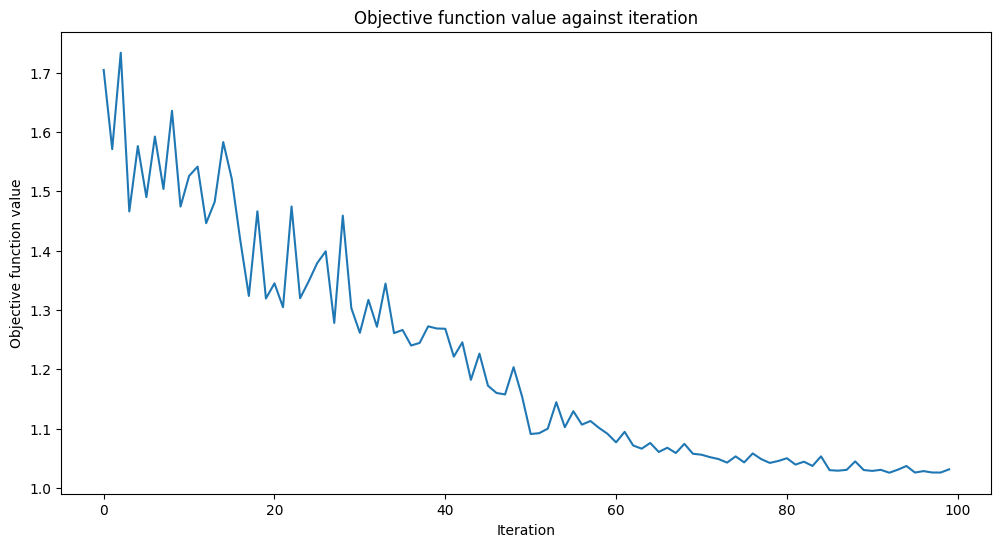

Training time: 44 seconds


In [22]:
sampler = Sampler()
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [23]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.88
Quantum VQC on the test dataset:     0.90
